In [1]:
#@title
 ###EP2MAC0417/MAC5768
 ##################################################################
 # AOPREENCHERESSECABEÇALHOCOMOMEUNOMEEOMEUNÚMEROUSP,#
 # DECLAROQUESOUOÚNICOAUTORERESPONSÁVELPELARESOLUÇÃO #
 # DESTEEP. #
 # TODASASPARTESFORAMDESENVOLVIDASEIMPLEMENTADASPORMIM, #
 # SEGUINDOASINSTRUÇÕESEQUEPORTANTO,NÃOCONSTITUEM #
 # DESONESTIDADEACADÊMICAOUPLÁGIO. #
 # #
 # DECLAROTAMBÉM,QUESOURESPONSÁVELPORTODASASCÓPIAS #
 # DESSEPROGRAMA,EQUEEUNÃODISTRIBUIOUFACILITEIA #
 # SUADISTRIBUIÇÃO.ESTOUCIENTEQUEOSCASOSDEPLÁGIOE #
 # DESONESTIDADEACADÊMICASERÃOTRATADOSSEGUNDOOSCRITÉRIOS #
 # DEFINIDOSNOCÓDIGODEÉTICADAUSP. #
 # #
 # ENTENDOQUEJUPYTERNOTEBOOKSSEMASSINATURANÃOSERÃO #
 # CORRIGIDOSE,AINDAASSIM,PODERÃOSERPUNIDOSPOR #
 # DESONESTIDADEACADÊMICA. #
 # #
 # #
 # Nome: João Pedro C. Feitosa
 # NUSP: 10741569
 # Turma: MAC0417
 # Prof.: Ronando Hashimoto
 #################################################################

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [3]:
metadados = pd.read_csv("metadados.csv")

### Criação de Diretórios

Antes de tudo, criaremos 4 diretórios dentro de da pasta *dados*: ***originalDataset***, ***originalGrayDataset***, ***augmentedDataset*** e ***normalizedDataset***:

In [4]:
for diretorio in ["originalDataset", "originalGrayDataset", "augmentedDataset", "normalizedDataset"]:
    caminho = f"dados/{diretorio}"
    if not os.path.exists(caminho):
        os.makedirs(caminho)

Adcionaremos as imagens originais, alocadas na pasta dados, ao diretório *originalDataset*:

In [5]:
for n in range(1,145):
    caminho = f"dados/{n:03d}.jpg"
    novo_caminho = f"dados/originalDataset/{n:03d}.jpg"
    if os.path.exists(caminho):
        os.rename(caminho, novo_caminho)

Criaremos 5 subdiretórios para casa transformação de data augmentation a ser realizada:
 - *constrast_stretching*
 - *log*
 - *exponencial*
 - *laplaciano*
 - *media*

In [6]:
for subdiretorio in ["constrast_stretching", "log", "exponencial", "laplaciano", "media"]:
    caminho = f"dados/augmentedDataset/{subdiretorio}"
    if not os.path.exists(caminho):
        os.makedirs(caminho)

### Funções

In [7]:
def mostrar_imagem(img, bw = True):
    plt.figure(figsize = (8,8))
    if bw == True:
        plt.imshow(img, cmap = "gray", vmin=0, vmax=255)
    else:
        plt.imshow(img)
    plt.axis("off")

#### Imagem Exemplo

In [8]:
caminho_exemplo = "dados/originalDataset/001.jpg"

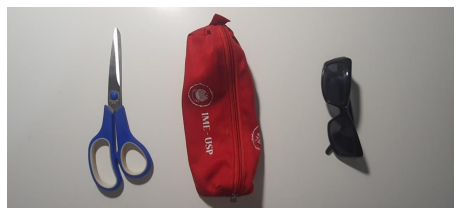

In [9]:
with open(caminho_exemplo, 'rb') as f:
    exemplo = plt.imread(f)
    mostrar_imagem(exemplo, bw = False)

#### RGBgray

In [10]:
def RGBgray(img):
    img = img.copy()
    
    rgb_array = [0.2989, 0.5870, 0.1140]
    img_resultante = np.dot(img, rgb_array)
    
    return img_resultante

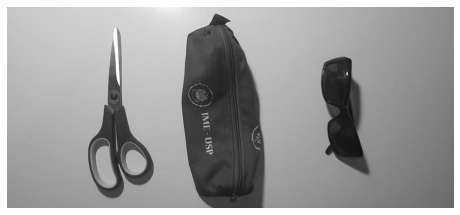

In [11]:
exemplo_cinza = RGBgray(exemplo)
mostrar_imagem(exemplo_cinza)

#### Constrast Stretching

In [12]:
def contrast_stretching(img, pontos, mostra_grafico = False):
    r1, s1, r2, s2 = pontos
    m1 = s1/r1
    m2 = (s2 - s1)/(r2 - r1)
    m3 = (255 - s2)/(255 - r2)

    def nova_intensidade(r):
        if r <= r1:
            s = m1*r
        elif r <= r2:
            s = m2*r + (s1 - m2*r1)
        else:
            s = m3*r + (s2 - m3*r2)

        return s

    if mostra_grafico == True:
        R = np.arange(256)
        S = np.array(list(map(nova_intensidade, R)))

        plt.plot(R, S, color='gray', linestyle='-')
        plt.plot(r1, s1, "bo")
        plt.plot(r2, s2, "bo")
        plt.text(r1 + 10, s1, f'({r1}, {s1})', fontsize = 10, va = 'center')
        plt.text(r2 + 10, s2 - 10, f'({r2}, {s2})', fontsize = 10, va = 'center')
        plt.xlabel("Input")
        plt.ylabel("Output")

    imagem_resultante = img.copy()

    for i in range(len(img)):
        for j in range(len(img[0])):
            r = img[i][j]
            imagem_resultante[i][j] = nova_intensidade(r)


    return imagem_resultante

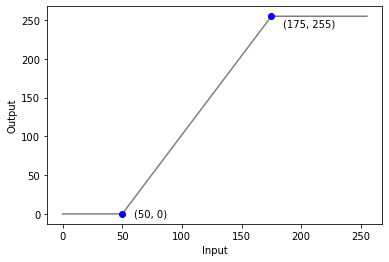

In [13]:
pontos_stretching = [50,0,175,255]

exemplo_stretched = contrast_stretching(exemplo_cinza, pontos_stretching, mostra_grafico = True)

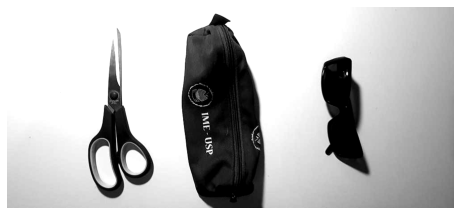

In [14]:
mostrar_imagem(exemplo_stretched)

#### Log Transformation

In [15]:
def transformacao_log(img, c):
    imagem_resultante = img.copy()
    for i in range(len(img)):
        for j in range(len(img[0])):
            p = img[i][j]
            imagem_resultante[i][j] = c * np.log(1 + p)
    
    return imagem_resultante

In [16]:
exemplo_log = transformacao_log(exemplo_cinza, 44)

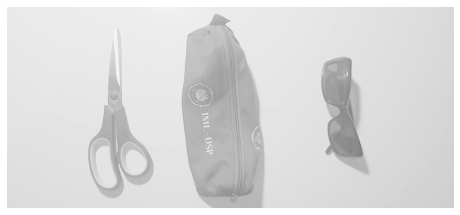

In [17]:
mostrar_imagem(exemplo_log)

#### Gamma Transformation (Exponencial)

In [18]:
def transformacao_gama(img, c, gama):
    imagem_resultante = img.copy()
    for i in range(len(img)):
        for j in range(len(img[0])):
            p = img[i][j]
            imagem_resultante[i][j] = c * p**gama
    
    return imagem_resultante

In [19]:
exemplo_gama = transformacao_gama(exemplo_cinza, 1.1, 0.8)

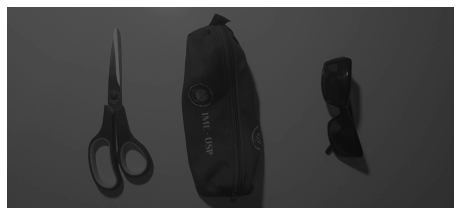

In [20]:
mostrar_imagem(exemplo_gama)

#### Laplaciano

In [21]:
def padding(img, dim_padding = 1):
    M, N = img.shape
    padded_img = np.zeros((M + 2 * dim_padding, N + 2 * dim_padding))
    padded_img[dim_padding:M + dim_padding, dim_padding:N + dim_padding] = img
    return padded_img

In [22]:
def convolucao(img, kernel):
    dim_kernel = len(kernel)
    dim_padding = int((dim_kernel - 1) / 2)
    
    img_padded = padding(img, dim_padding)
    M, N = img.shape
    imagem_resultante = np.zeros((M, N))
    
    for i in range(M - 1):
        for j in range(N - 1):
            soma = 0
            for m in range(dim_kernel):
                for n in range(dim_kernel):
                    soma += img_padded[i + m][j + n] * kernel[m][n]
            imagem_resultante[i][j] = soma
            
    return imagem_resultante

In [23]:
kernel_laplaciano = [
    [0, 8, 0],
    [8, -32, 8],
    [0, 8, 0]
]

In [24]:
exemplo_laplaciano = convolucao(exemplo_cinza, kernel_laplaciano)

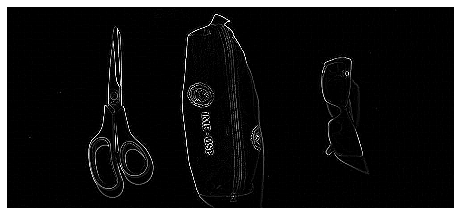

In [25]:
mostrar_imagem(exemplo_laplaciano)

#### Filtro Média

In [26]:
kernel_media = [
    [1/25, 1/25, 1/25, 1/25, 1/25],
    [1/25, 1/25, 1/25, 1/25, 1/25],
    [1/25, 1/25, 1/25, 1/25, 1/25],
    [1/25, 1/25, 1/25, 1/25, 1/25],
    [1/25, 1/25, 1/25, 1/25, 1/25]
]

In [27]:
exemplo_media = convolucao(exemplo_cinza, kernel_media)

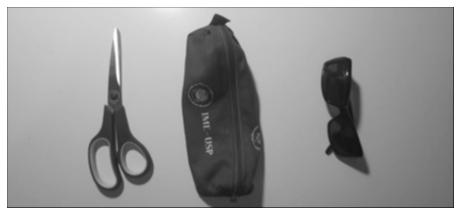

In [28]:
mostrar_imagem(exemplo_media)

### Aplicação

E com isso, temos as seguintes transformações:

In [29]:
imagens = {"Original": exemplo,
           "Constrast Stretching": exemplo_stretched,
           "Log": exemplo_log,
           "Exponencial": exemplo_gama,
           "Laplaciano": exemplo_laplaciano,
           "Media": exemplo_media
          }

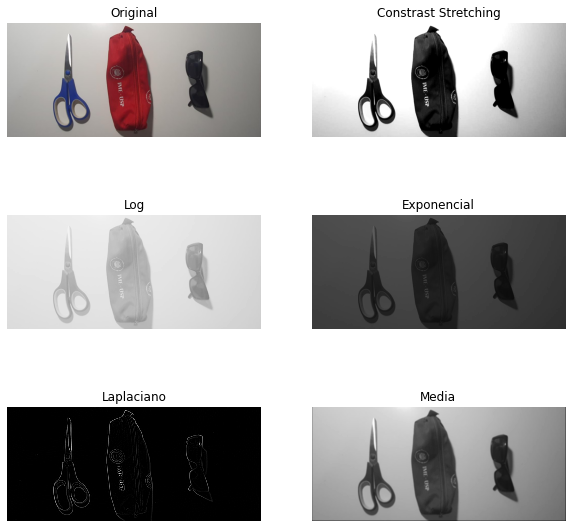

In [30]:
plt.figure(figsize = (10,10))

for n, tipo_imagem in enumerate(imagens):
    plt.subplot(3,2,n+1)
    plt.axis("off")
    plt.imshow(imagens[tipo_imagem], cmap = "gray", vmin=0, vmax=255)
    plt.title(f"{tipo_imagem}")

Aplicaremos cada uma das transformações no dataset original em escala de cinza. Vamos criá-lo:

In [31]:
for n in range(1,145):
    caminho = f"dados/originalDataset/{n:03d}.jpg"
    novo_caminho = f"dados/originalGrayDataset/{n:03d}.jpg"
    if not os.path.exists(novo_caminho):
        with open(caminho, 'rb') as f:
            imagem = plt.imread(f)

        imagem_cinza = RGBgray(imagem)
        plt.imsave(novo_caminho, imagem_cinza, cmap = "gray", format = "jpg")

Mas antes de aplicar as transformações log e exponencial, criaremos funções que determinam os parâmetros utilizados com base nos metadados da imagens:

In [32]:
def c_log(n):
    luz = metadados["luz"][n - 1]
    
    valor_c = {1: 41,
               2: 42,
               3: 43,
               4: 44}
    
    return valor_c[luz]

In [33]:
def c_exponencial(n):
    luz = metadados["luz"][n - 1]
    
    valor_c = {1: 1.1,
               2: 1.2,
               3: 1.3,
               4: 1.4}
    
    return valor_c[luz]

In [34]:
def gama_exponencial(n):
    luz = metadados["luz"][n - 1]
    
    valor_gama = {1: 0.8,
               2: 0.775,
               3: 0.75,
               4: 0.70}
    
    return valor_gama[luz]

Agora, aplicaremos as funções desenvolvidas para criar as novas bases de dados:

***Contrast Stretching:***

In [35]:
for n in range(1,145):
    caminho = f"dados/originalGrayDataset/{n:03d}.jpg"
    novo_caminho = f"dados/augmentedDataset/constrast_stretching/{n:03d}.jpg"
    if not os.path.exists(novo_caminho):
        with open(caminho, 'rb') as f:
            imagem = plt.imread(f)[:, :, 0]

        imagem_resultante = contrast_stretching(imagem, pontos = [50,0,175,255])
        plt.imsave(novo_caminho, imagem_resultante, cmap = "gray", format = "jpg")

***Log***

In [36]:
for n in range(1,145):
    caminho = f"dados/originalGrayDataset/{n:03d}.jpg"
    novo_caminho = f"dados/augmentedDataset/log/{n:03d}.jpg"
    if not os.path.exists(novo_caminho):
        with open(caminho, 'rb') as f:
            imagem = plt.imread(f)[:, :, 0]

        imagem_resultante = transformacao_log(imagem, c = c_log(n))
        plt.imsave(novo_caminho, imagem_resultante, cmap = "gray", format = "jpg")

#### Exponencial

In [37]:
for n in range(1,145):
    caminho = f"dados/originalGrayDataset/{n:03d}.jpg"
    novo_caminho = f"dados/augmentedDataset/exponencial/{n:03d}.jpg"
    if not os.path.exists(novo_caminho):
        with open(caminho, 'rb') as f:
            imagem = plt.imread(f)[:, :, 0]

        imagem_resultante = transformacao_gama(imagem, c = c_exponencial(n), gama = gama_exponencial(n))
        cv2.imwrite(novo_caminho, imagem_resultante)

***Laplaciano***

In [99]:
kernel_laplaciano = [
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
]

In [100]:
for n in range(1,145):
    caminho = f"dados/originalGrayDataset/{n:03d}.jpg"
    novo_caminho = f"dados/augmentedDataset/laplaciano/{n:03d}.jpg"
    if not os.path.exists(novo_caminho):
        with open(caminho, 'rb') as f:
            imagem = plt.imread(f)[:, :, 0]

        imagem_resultante = convolucao(imagem, kernel_laplaciano)
        cv2.imwrite(novo_caminho, imagem_resultante)

É válido comentar que muitas imagens resultantes da convolução aplicando o kernel laplaciano foram insatisfatórias. Comparando os resultados obtidos com os oferecidos pela função *Laplacian* da biblioteca cv2, entretanto, pudemos observar resultados semelhantes.

***Média***

In [101]:
kernel_media = [
    [1/25, 1/25, 1/25, 1/25, 1/25],
    [1/25, 1/25, 1/25, 1/25, 1/25],
    [1/25, 1/25, 1/25, 1/25, 1/25],
    [1/25, 1/25, 1/25, 1/25, 1/25],
    [1/25, 1/25, 1/25, 1/25, 1/25]
]

In [102]:
for n in range(1,145):
    caminho = f"dados/originalGrayDataset/{n:03d}.jpg"
    novo_caminho = f"dados/augmentedDataset/media/{n:03d}.jpg"
    if not os.path.exists(novo_caminho):
        with open(caminho, 'rb') as f:
            imagem = plt.imread(f)[:, :, 0]

        imagem_resultante = convolucao(imagem, kernel_media)
        cv2.imwrite(novo_caminho, imagem_resultante)

Pronto. Os 5 novos datasets foram criados!

### Visualização

In [118]:
def mostra_dataset(diretorio):
    
    # determina o número de colunas e linhas do grid
    
    n_colunas = 8
    n_linhas = 18
    
    # preenche o grid com imagens correspondentes ao dataset escolhido
    
    plt.figure(figsize = (12,12))
    plt.suptitle(f"Imagens - Dataset: {diretorio}")
    
    for i in range(1,145):
        caminho = f"dados/{diretorio}/{i:03d}.jpg"
        plt.subplot(n_linhas,n_colunas,i)
        with open(caminho, 'rb') as f:
            imagem = plt.imread(f)
        plt.imshow(imagem, cmap = "gray", vmin=0, vmax=255)
        plt.axis("off")
        
    plt.show()

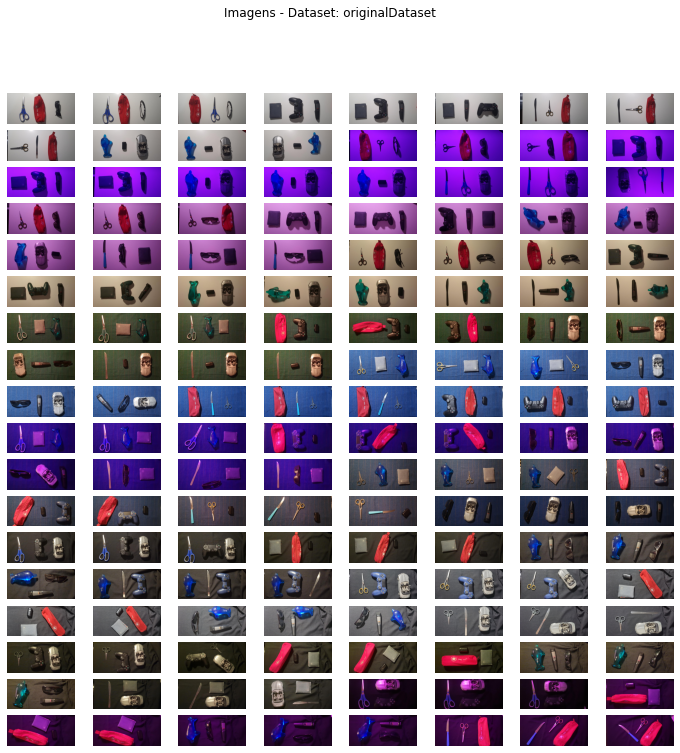

In [126]:
mostra_dataset("originalDataset")

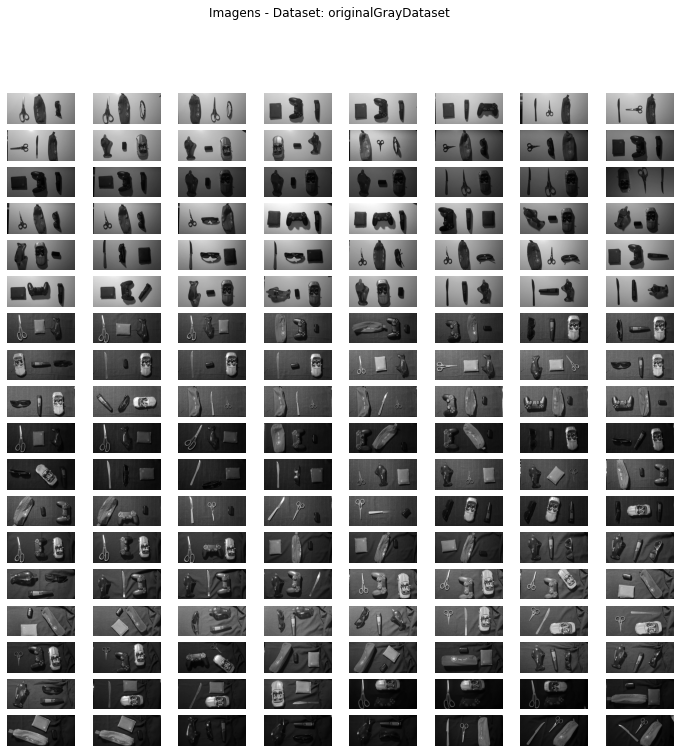

In [120]:
mostra_dataset("originalGrayDataset")

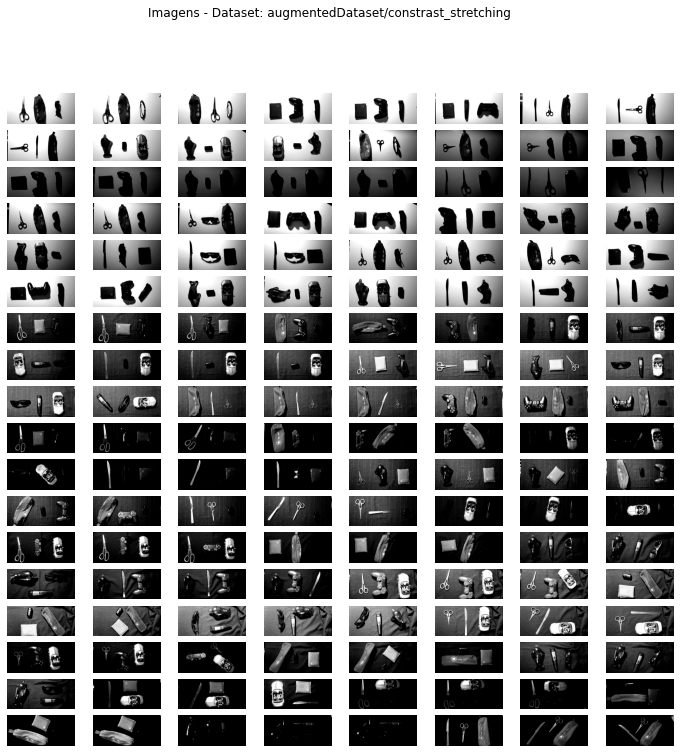

In [121]:
mostra_dataset("augmentedDataset/constrast_stretching")

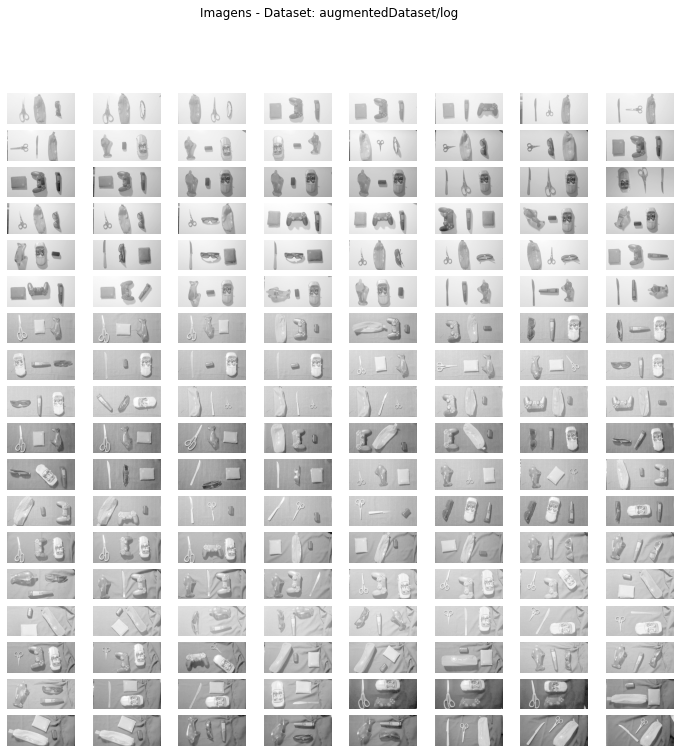

In [122]:
mostra_dataset("augmentedDataset/log")

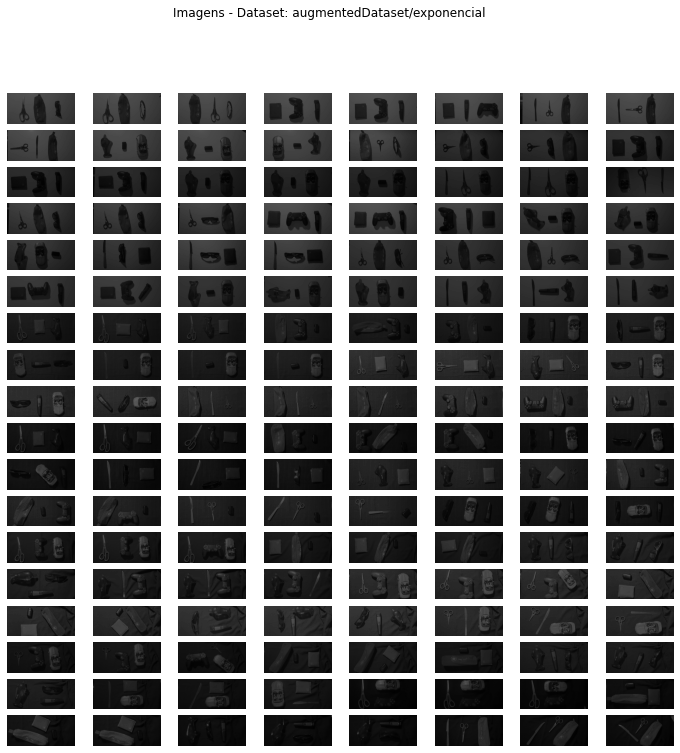

In [123]:
mostra_dataset("augmentedDataset/exponencial")

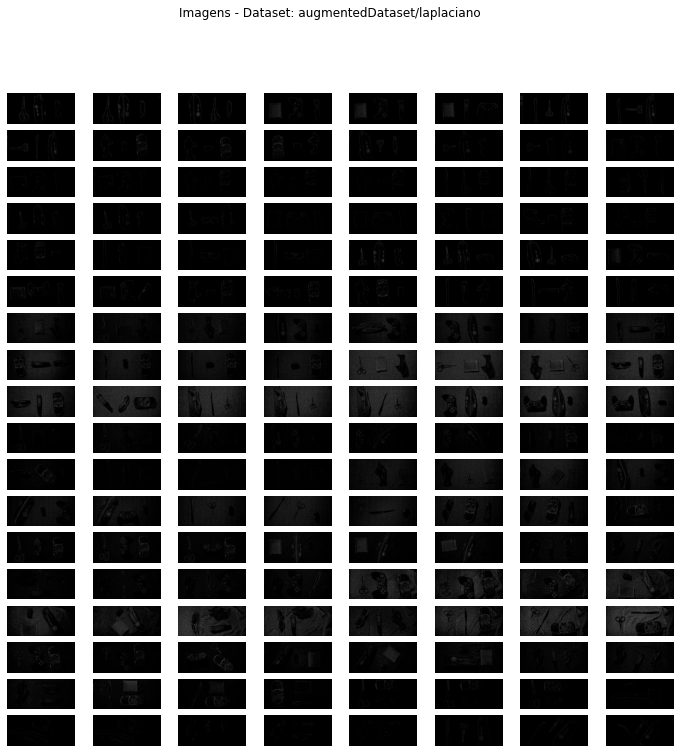

In [124]:
mostra_dataset("augmentedDataset/laplaciano")

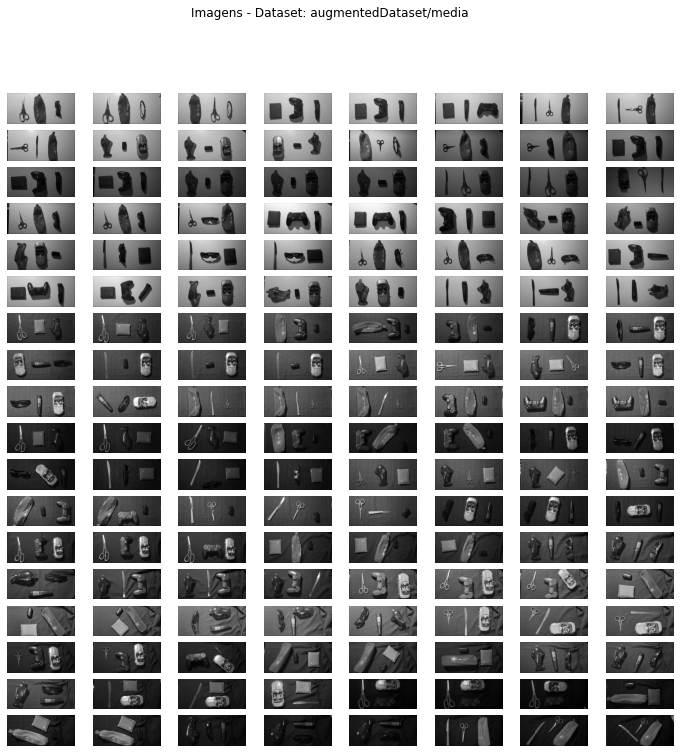

In [125]:
mostra_dataset("augmentedDataset/media")